In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import scipy.stats as stats
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

In [5]:
from network_analysis.flow_assignment import FlowAssignment
from network_analysis.geodf_network import GeoDataNetwork
from geoprocessing.faf_zone_network import FafZoneNetwork
from geoprocessing.temperature_overlay.overlay_spear import join_tas_diff, load_tas_diff
from network_analysis.mc_flow_assignment import sample_flows
import geopandas as gpd

In [6]:
SIMPLE_NET = False # (421, 423, 341, 342 )

MONTE_CARLO = False
MC_ITER_N = 500
NORMAL_DIST = True

COLUMN = 'thousand tons in 2035'

# Validations
if SIMPLE_NET:
  MONTE_CARLO = False
  

In [7]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/faf_zones_exploded").to_crs(4326)


In [8]:
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
faf_flows = pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow_exploded.csv' )
railnet = fzn.createNetwork()

fa = FlowAssignment(railnet)

railnet_flows = fa(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode

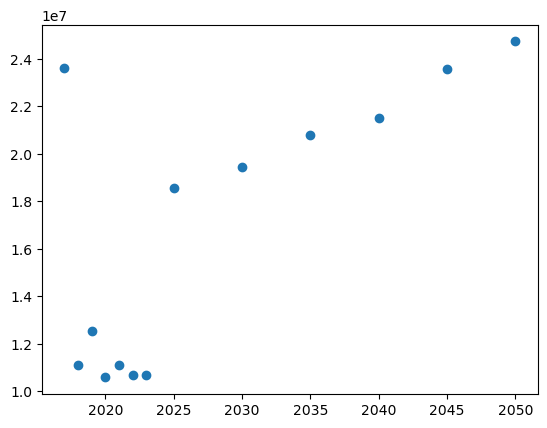

In [9]:
xs = [
2017,
2018,
2019,
2020,
2021,
2022,
2023,
2025,
2030,
2035,
2040,
2045,
2050,
]

ys = [2.361409e+07,
1.112043e+07,
1.252375e+07,
1.058251e+07,
1.110781e+07,
1.067079e+07,
1.070599e+07,
1.858400e+07,
1.944830e+07,
2.080019e+07,
2.150299e+07,
2.356595e+07,
2.473456e+07]

from matplotlib import pyplot as plt

plt.scatter(xs, ys)


In [10]:
fa = FlowAssignment(railnet)

railnet_flows = fa(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode

if not MONTE_CARLO:
  fzn.apply_flows(railnet_flows.to_dict())
  # fzn.apply_flows(link_weights(fzn.fafZoneLinksDf))
if MONTE_CARLO:
  monte_railnet_flows = []
  monte_inputs = []
  for i in range(MC_ITER_N):
    iteration_inputs = sample_flows(faf_flows, COLUMN, distribution='normal' if NORMAL_DIST else 'triangular')
    monte_inputs.append(iteration_inputs)
    faf_flows['input_flows'] = iteration_inputs
    iteration_flow = fa.run(faf_flows, SUM_COLUMN='input_flows')
    monte_railnet_flows.append(iteration_flow)
  monte_railnet_flows = pd.concat(monte_railnet_flows, axis=1)
  monte_railnet_flows.columns=range(MC_ITER_N)
  fzn.fafZoneLinksDf['flows'] = monte_railnet_flows.mean(axis=1)
  fzn.fafZoneLinksDf['flow_covs'] = monte_railnet_flows.std(axis=1) / monte_railnet_flows.mean(axis=1)
  railnet_flows.index = railnet_flows.index.set_names({'seg_start':'FAF_Zone_fr', 'seg_end':'FAF_Zone_to'})
  fzn.fafZoneLinksDf['flow_df'] = (fzn.fafZoneLinksDf['flows'] - railnet_flows).abs()
  fzn.fafZoneLinksDf['flow_df_percent'] = fzn.fafZoneLinksDf['flow_df'] / railnet_flows

# Unweighted Network

In [11]:
baseline_faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  # lambda df : df['flows'],
  lambda df : 1,
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='centrality'
)

baseline_faf_geonet.calculate_centrality(weighted=False)
faf_railnet = baseline_faf_geonet.createNetwork(NAME='FAF')
baseline_faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(baseline_faf_geonet.show_map())
baseline_faf_geonet.show_values()

,FAF_Zone_1,centrality
FAF_Zone,,
219,Remainder of Kentucky,0.465028
179,Remainder of Illinois,0.358933
429,Remainder of Pennsylvania,0.245991
299,Remainder of Missouri,0.226317
489,Remainder of Texas,0.161161
540,West Virginia,0.148282
369,Remainder of New York,0.141527
519,Remainder of Virginia,0.130659
2399,Remainder of Ohio,0.126260


FAF_Zone_1_fr  \
FAF_Zone_fr FAF_Zone_to                                     
179         219                     Remainder of Illinois   
            299                     Remainder of Illinois   
369         429                     Remainder of New York   
219         540                     Remainder of Kentucky   
            2399                    Remainder of Kentucky   
361         369          Albany-Schenectady, NY  CFS Area   
429         540                 Remainder of Pennsylvania   
179         190                     Remainder of Illinois   
49          350                      Remainder of Arizona   
429         2399                Remainder of Pennsylvania   

                                     FAF_Zone_1_to  centrality  
FAF_Zone_fr FAF_Zone_to                                         
179         219              Remainder of Kentucky    0.278785  
            299              Remainder of Missouri    0.198187  
369         429          Remainder of Pennsylvania    0.148452  
219         540                      West Virginia    0.135070  
            2399                 Remainder of Ohio    0.118641  
361         369              Remainder of New York    0.113553  
429         540                      West Virginia    0.109560  
179         190                               Iowa    0.109054  
49          350                         New Mexico    0.108332  
429         2399                 Remainder of Ohio    0.105765

# Freight Tonnage Weighted

## Freight Tonnage

In [12]:
faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  lambda df : 0,
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='flows'
)

faf_geonet.calculate_centrality()
faf_railnet = faf_geonet.createNetwork(NAME='FAF')
faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(faf_geonet.show_map())
faf_geonet.show_values()

,FAF_Zone_1,flows
FAF_Zone,,
61,"Los Angeles-Long Beach, CA CFS Area",2.348032e+07
49,Remainder of Arizona,1.282123e+07
219,Remainder of Kentucky,7.499376e+06
179,Remainder of Illinois,7.442690e+06
4069,Remainder of California,6.984260e+06
363,"New York-Newark, NY-NJ-CT-PA CFS Area (NY Part)",6.533530e+06
190,Iowa,6.045752e+06
369,Remainder of New York,4.518809e+06
319,Remainder of Nebraska,3.943476e+06


FAF_Zone_1_fr  \
FAF_Zone_fr FAF_Zone_to                                                     
49          61                                       Remainder of Arizona   
61          4069                     Los Angeles-Long Beach, CA  CFS Area   
363         369          New York-Newark, NY-NJ-CT-PA  CFS Area (NY Part)   
61          63                       Los Angeles-Long Beach, CA  CFS Area   
92          363          New York-Newark, NY-NJ-CT-PA  CFS Area (CT Part)   
190         319                                                      Iowa   
179         190                                     Remainder of Illinois   
            219                                     Remainder of Illinois   
261         269                    Detroit-Warren-Ann Arbor, MI  CFS Area   
61          321                      Los Angeles-Long Beach, CA  CFS Area   

                                                            FAF_Zone_1_to  \
FAF_Zone_fr FAF_Zone_to                                                     
49          61                       Los Angeles-Long Beach, CA  CFS Area   
61          4069                                  Remainder of California   
363         369                                     Remainder of New York   
61          63                           San Diego-Carlsbad, CA  CFS Area   
92          363          New York-Newark, NY-NJ-CT-PA  CFS Area (NY Part)   
190         319                                     Remainder of Nebraska   
179         190                                                      Iowa   
            219                                     Remainder of Kentucky   
261         269                                     Remainder of Michigan   
61          321            Las Vegas-Henderson, NV-AZ  CFS Area (NV Part)   

                                flows  
FAF_Zone_fr FAF_Zone_to                
49          61           2.391455e+07  
61          4069         1.315985e+07  
363         369          6.544189e+06  
61          63           5.495002e+06  
92          363          5.371918e+06  
190         319          4.818200e+06  
179         190          4.729298e+06  
            219          4.624769e+06  
261         269          4.231779e+06  
61          321          3.752480e+06

<Axes: title={'center': 'Histogram of Freight Flows at FAF Network Edges for 2050'}, xlabel='Edge Freight Flow (in thousands of tons)', ylabel='Frequency'>

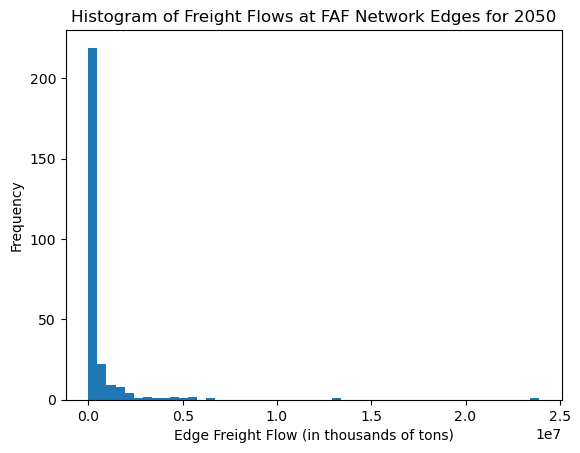

In [13]:
faf_geonet.edgeDf[faf_geonet.VALUE].plot(
  kind='hist',
  bins=50,
  xlabel='Edge Freight Flow (in thousands of tons)',
  title='Histogram of Freight Flows at FAF Network Edges for 2050'
)

## Node / Link importances

In [14]:
flow_faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  lambda df : -df['flows'],
  # lambda df : 0,
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='centrality'
)

flow_faf_geonet.calculate_centrality()
faf_railnet = flow_faf_geonet.createNetwork(NAME='FAF')
flow_faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(flow_faf_geonet.show_map())
flow_faf_geonet.show_values()

,FAF_Zone_1,centrality
FAF_Zone,,
190,Iowa,0.919867
179,Remainder of Illinois,0.916429
319,Remainder of Nebraska,0.914842
560,Wyoming,0.896805
160,Idaho,0.816672
489,Remainder of Texas,0.762456
50,Arkansas,0.728499
219,Remainder of Kentucky,0.719772
61,"Los Angeles-Long Beach, CA CFS Area",0.587961


,,FAF_Zone_1_fr,FAF_Zone_1_to,centrality
FAF_Zone_fr,FAF_Zone_to,,,
190,319,Iowa,Remainder of Nebraska,0.914972
319,560,Remainder of Nebraska,Wyoming,0.895475
179,190,Remainder of Illinois,Iowa,0.882859
160,560,Idaho,Wyoming,0.802263
50,489,Arkansas,Remainder of Texas,0.696173
49,61,Remainder of Arizona,"Los Angeles-Long Beach, CA CFS Area",0.586487
64,5069,"San Jose-San Francisco-Oakland, CA CFS Area",Remainder of California,0.575175
429,540,Remainder of Pennsylvania,West Virginia,0.567407
64,4069,"San Jose-San Francisco-Oakland, CA CFS Area",Remainder of California,0.562871


# Temperature

In [15]:
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
tas_diff_df = load_tas_diff(BASE_DIR / "inputs/spear_tas_diff.nc")
fzn.fafZoneNodesDf['tas'] = join_tas_diff(fzn.fafZoneNodesDf.drop(columns=['index_right']), tas_diff_df)
fzn._fafZoneLinksDf = None
fzn.fafZoneLinksDf['tas'] = join_tas_diff(fzn.fafZoneLinksDf, tas_diff_df)

fa = FlowAssignment(fzn.createNetwork())

railnet_flows = fa(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode

fzn.apply_flows(railnet_flows.to_dict())

geometry  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19           LINESTRING (-86.76365 33.47538, -86.78008 33.0...   
12          19           LINESTRING (-88.06251 30.72613, -86.78008 33.0...   
            280          LINESTRING (-88.06251 30.72613, -89.48377 32.5...   
            4129         LINESTRING (-88.06251 30.72613, -84.7611 30.22...   
19          131          LINESTRING (-86.78008 33.0568, -84.37138 33.80...   
...                                                                    ...   
531         539          LINESTRING (-122.37721 47.46371, -119.26865 47...   
532         539          LINESTRING (-122.76488 45.88636, -119.26865 47...   
540         2399         LINESTRING (-81.02183 38.58522, -81.5012 40.06...   
551         559          LINESTRING (-88.19888 43.0759, -89.63998 44.41...   
1479        3379         LINESTRING (-82.64762 36.4054, -82.06291 35.64...   

                         FRAARCID                  geometry_fr COUNTRY_fr  \
FAF_Zone_fr FAF_Zone_to                                                     
11          19                 19   POINT (-86.76365 33.47538)         US   
12          19                  2   POINT (-88.06251 30.72613)         US   
            280                 2   POINT (-88.06251 30.72613)         US   
            4129                2   POINT (-88.06251 30.72613)         US   
19          131                 4    POINT (-86.78008 33.0568)         US   
...                           ...                          ...        ...   
531         539                 6  POINT (-122.37721 47.46371)         US   
532         539                 1  POINT (-122.76488 45.88636)         US   
540         2399                7   POINT (-81.02183 38.58522)         US   
551         559                15    POINT (-88.19888 43.0759)         US   
1479        3379                1    POINT (-82.64762 36.4054)         US   

                        STATE_fr STFIPS_fr CTYFIPS_fr STCYFIPS_fr  \
FAF_Zone_fr FAF_Zone_to                                             
11          19                AL        01        127       01127   
12          19                AL        01        097       01097   
            280               AL        01        097       01097   
            4129              AL        01        097       01097   
19          131               AL        01        023       01023   
...                          ...       ...        ...         ...   
531         539               WA        53        045       53045   
532         539               WA        53        015       53015   
540         2399              WV        54        099       54099   
551         559               WI        55        055       55055   
1479        3379              TN        47        013       47013   

                         FRADISTRCT_fr PASSNGR_fr  ... FAF_Zone_D_to  \
FAF_Zone_fr FAF_Zone_to                            ...                 
11          19                       3          A  ...    Rest of AL   
12          19                       3          A  ...    Rest of AL   
            280                      3          A  ...   Mississippi   
            4129                     3          A  ...    Rest of FL   
19          131                      3          A  ...    Atlanta GA   
...                                ...        ...  ...           ...   
531         539                      8          A  ...    Rest of WA   
532         539                      8          A  ...    Rest of WA   
540         2399                     2          A  ...    Rest of OH   
551         559                      4          A  ...    Rest of WI   
1479        3379                     3       None  ...    Rest of NC   

                                                             FAF_Zone_1_to  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19                                        Rema

In [16]:
faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  # lambda df : df['flows'],
  lambda df : 1,
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='tas'
)

faf_railnet = faf_geonet.createNetwork(NAME='FAF')
faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(faf_geonet.show_map(color_nodes=True))
faf_geonet.show_values()

,FAF_Zone_1,tas
FAF_Zone,,
20,Alaska,7.070343
380,North Dakota,6.511322
230,Maine,6.475433
500,Vermont,6.436005
339,Remainder of New Hampshire,6.385620
259,Remainder of Massachusetts,6.272552
331,"Boston-Worcester-Providence, MA-RI-NH-CT CFS ...",6.268188
279,Remainder of Minnesota,6.244659
369,Remainder of New York,6.229248


,,FAF_Zone_1_fr,FAF_Zone_1_to,tas
FAF_Zone_fr,FAF_Zone_to,,,
230,339,Maine,Remainder of New Hampshire,6.489105
279,380,Remainder of Minnesota,North Dakota,6.483856
339,500,Remainder of New Hampshire,Vermont,6.436005
380,460,North Dakota,South Dakota,6.385834
259,500,Remainder of Massachusetts,Vermont,6.363983
331,339,"Boston-Worcester-Providence, MA-RI-NH-CT CFS ...",Remainder of New Hampshire,6.287140
92,259,"New York-Newark, NY-NJ-CT-PA CFS Area (CT Part)",Remainder of Massachusetts,6.272552
91,259,"Hartford-West Hartford-East Hartford, CT CFS ...",Remainder of Massachusetts,6.272552
259,361,Remainder of Massachusetts,"Albany-Schenectady, NY CFS Area",6.272552


In [23]:
temp_faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  lambda df : -df['tas'],
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='centrality'
)

temp_faf_geonet.calculate_centrality(weighted=True)
faf_railnet = temp_faf_geonet.createNetwork(NAME='FAF')
temp_faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(temp_faf_geonet.show_map())
temp_faf_geonet.show_values()

,FAF_Zone_1,centrality
FAF_Zone,,
380,North Dakota,0.787105
279,Remainder of Minnesota,0.786258
460,South Dakota,0.780493
190,Iowa,0.774410
319,Remainder of Nebraska,0.769809
409,Remainder of Oklahoma,0.729028
429,Remainder of Pennsylvania,0.692849
209,Remainder of Kansas,0.691103
540,West Virginia,0.688194


FAF_Zone_1_fr  \
FAF_Zone_fr FAF_Zone_to                                                      
279         380                                     Remainder of Minnesota   
190         460                                                       Iowa   
209         319                                        Remainder of Kansas   
422         540          Pittsburgh-New Castle-Weirton, PA-OH-WV  CFS A...   
202         209               Wichita-Arkansas City-Winfield, KS  CFS Area   
            409               Wichita-Arkansas City-Winfield, KS  CFS Area   
190         319                                                       Iowa   
89          409                                      Remainder of Colorado   
269         559                                      Remainder of Michigan   
49          61                                        Remainder of Arizona   

                                                FAF_Zone_1_to  centrality  
FAF_Zone_fr FAF_Zone_to                                                    
279         380                                  North Dakota    0.781670  
190         460                                  South Dakota    0.763424  
209         319                         Remainder of Nebraska    0.678918  
422         540                                 West Virginia    0.676780  
202         209                           Remainder of Kansas    0.672818  
            409                         Remainder of Oklahoma    0.659681  
190         319                         Remainder of Nebraska    0.615994  
89          409                         Remainder of Oklahoma    0.615734  
269         559                      Remainder of Wisconsin\r    0.608748  
49          61           Los Angeles-Long Beach, CA  CFS Area    0.590397

In [18]:
from utils import normalize_reverse

combined_faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  lambda df : normalize_reverse(df['tas']) * normalize_reverse(df['flows']),
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='centrality'
)

combined_faf_geonet.calculate_centrality(weighted=True)
faf_railnet = combined_faf_geonet.createNetwork(NAME='FAF')
combined_faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(combined_faf_geonet.show_map())
combined_faf_geonet.show_values()

,FAF_Zone_1,centrality
FAF_Zone,,
219,Remainder of Kentucky,0.500159
179,Remainder of Illinois,0.416958
540,West Virginia,0.272929
429,Remainder of Pennsylvania,0.246483
319,Remainder of Nebraska,0.183011
559,Remainder of Wisconsin\r,0.178673
369,Remainder of New York,0.162382
279,Remainder of Minnesota,0.151169
380,North Dakota,0.150376


FAF_Zone_1_fr  \
FAF_Zone_fr FAF_Zone_to                                     
179         219                     Remainder of Illinois   
219         540                     Remainder of Kentucky   
49          61                       Remainder of Arizona   
429         540                 Remainder of Pennsylvania   
369         429                     Remainder of New York   
279         380                    Remainder of Minnesota   
            559                    Remainder of Minnesota   
179         190                     Remainder of Illinois   
361         369          Albany-Schenectady, NY  CFS Area   
179         559                     Remainder of Illinois   

                                                FAF_Zone_1_to  centrality  
FAF_Zone_fr FAF_Zone_to                                                    
179         219                         Remainder of Kentucky    0.372745  
219         540                                 West Virginia    0.237775  
49          61           Los Angeles-Long Beach, CA  CFS Area    0.229330  
429         540                                 West Virginia    0.218069  
369         429                     Remainder of Pennsylvania    0.168543  
279         380                                  North Dakota    0.152539  
            559                      Remainder of Wisconsin\r    0.149984  
179         190                                          Iowa    0.139871  
361         369                         Remainder of New York    0.135492  
179         559                      Remainder of Wisconsin\r    0.133615

In [19]:
baseline_sample = baseline_faf_geonet.nodeDf[['FAF_Zone_1', 'centrality']].sort_values('centrality', ascending=False)

baseline_sample['flow_centrality'] = flow_faf_geonet.nodeDf.loc[baseline_sample.index, 'centrality']


baseline_sample['temp_centrality'] = combined_faf_geonet.nodeDf.loc[baseline_sample.index, 'centrality']
baseline_sample['diff_centrality'] = baseline_sample['centrality'] - baseline_sample['temp_centrality']

baseline_sample.head(5)[['FAF_Zone_1', 'centrality', 'flow_centrality', 'temp_centrality', 'diff_centrality']]

,FAF_Zone_1,centrality,flow_centrality,temp_centrality,diff_centrality
FAF_Zone,,,,,
219,Remainder of Kentucky,0.465028,0.719772,0.500159,-0.035131
179,Remainder of Illinois,0.358933,0.916429,0.416958,-0.058024
429,Remainder of Pennsylvania,0.245991,0.586745,0.246483,-0.000491
299,Remainder of Missouri,0.226317,0.459061,0.124775,0.101542
489,Remainder of Texas,0.161161,0.762456,0.127208,0.033953


<Axes: title={'center': 'Difference in Centrality between Baseline and Flow Networks'}, xlabel='Change in centrality', ylabel='Frequency'>

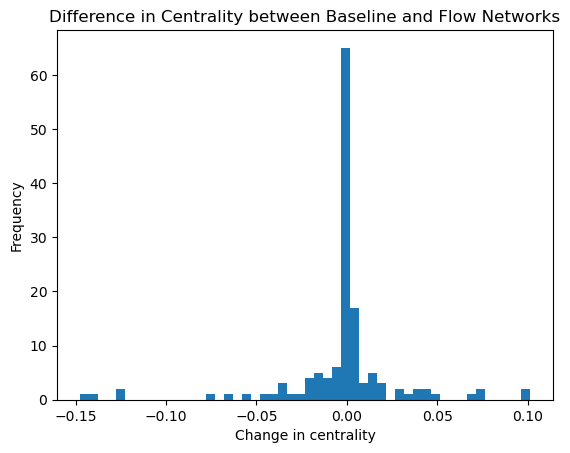

In [20]:
baseline_sample['diff_centrality'].plot(kind='hist', bins=50, xlabel='Change in centrality', title='Difference in Centrality between Baseline and Flow Networks')

In [21]:
baseline_faf_geonet.edgeDf

geometry  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19           LINESTRING (-86.76365 33.47538, -86.78008 33.0...   
12          19           LINESTRING (-88.06251 30.72613, -86.78008 33.0...   
            280          LINESTRING (-88.06251 30.72613, -89.48377 32.5...   
            4129         LINESTRING (-88.06251 30.72613, -84.7611 30.22...   
19          131          LINESTRING (-86.78008 33.0568, -84.37138 33.80...   
...                                                                    ...   
531         539          LINESTRING (-122.37721 47.46371, -119.26865 47...   
532         539          LINESTRING (-122.76488 45.88636, -119.26865 47...   
540         2399         LINESTRING (-81.02183 38.58522, -81.5012 40.06...   
551         559          LINESTRING (-88.19888 43.0759, -89.63998 44.41...   
1479        3379         LINESTRING (-82.64762 36.4054, -82.06291 35.64...   

                         FRAARCID                  geometry_fr COUNTRY_fr  \
FAF_Zone_fr FAF_Zone_to                                                     
11          19                 19   POINT (-86.76365 33.47538)         US   
12          19                  2   POINT (-88.06251 30.72613)         US   
            280                 2   POINT (-88.06251 30.72613)         US   
            4129                2   POINT (-88.06251 30.72613)         US   
19          131                 4    POINT (-86.78008 33.0568)         US   
...                           ...                          ...        ...   
531         539                 6  POINT (-122.37721 47.46371)         US   
532         539                 1  POINT (-122.76488 45.88636)         US   
540         2399                7   POINT (-81.02183 38.58522)         US   
551         559                15    POINT (-88.19888 43.0759)         US   
1479        3379                1    POINT (-82.64762 36.4054)         US   

                        STATE_fr STFIPS_fr CTYFIPS_fr STCYFIPS_fr  \
FAF_Zone_fr FAF_Zone_to                                             
11          19                AL        01        127       01127   
12          19                AL        01        097       01097   
            280               AL        01        097       01097   
            4129              AL        01        097       01097   
19          131               AL        01        023       01023   
...                          ...       ...        ...         ...   
531         539               WA        53        045       53045   
532         539               WA        53        015       53015   
540         2399              WV        54        099       54099   
551         559               WI        55        055       55055   
1479        3379              TN        47        013       47013   

                         FRADISTRCT_fr PASSNGR_fr  ...  \
FAF_Zone_fr FAF_Zone_to                            ...   
11          19                       3          A  ...   
12          19                       3          A  ...   
            280                      3          A  ...   
            4129                     3          A  ...   
19          131                      3          A  ...   
...                                ...        ...  ...   
531         539                      8          A  ...   
532         539                      8          A  ...   
540         2399                     2          A  ...   
551         559                      4          A  ...   
1479        3379                     3       None  ...   

                                                             CFS17_NA_1_to  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19                                        Remainder of Alabama   
12          19                                        Remainder of Alabama   
            280                                   Remainder of Mississippi   
      

In [22]:
baseline_sample = baseline_faf_geonet.edgeDf[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'centrality', 'geometry']].sort_values('centrality', ascending=False)

baseline_sample['flow_centrality'] = flow_faf_geonet.edgeDf.loc[baseline_sample.index, 'centrality']


baseline_sample['temp_centrality'] = combined_faf_geonet.edgeDf.loc[baseline_sample.index, 'centrality']
baseline_sample['diff_centrality'] = baseline_sample['centrality'] - baseline_sample['temp_centrality']

baseline_sample.head(5)

FAF_Zone_1_fr              FAF_Zone_1_to  \
FAF_Zone_fr FAF_Zone_to                                                     
179         219          Remainder of Illinois      Remainder of Kentucky   
            299          Remainder of Illinois      Remainder of Missouri   
369         429          Remainder of New York  Remainder of Pennsylvania   
219         540          Remainder of Kentucky              West Virginia   
            2399         Remainder of Kentucky          Remainder of Ohio   

                         centrality  \
FAF_Zone_fr FAF_Zone_to               
179         219            0.278785   
            299            0.198187   
369         429            0.148452   
219         540            0.135070   
            2399           0.118641   

                                                                  geometry  \
FAF_Zone_fr FAF_Zone_to                                                      
179         219          LINESTRING (-89.21121 40.05486, -85.37389 37.4...   
            299          LINESTRING (-89.21121 40.05486, -92.43634 38.1...   
369         429          LINESTRING (-76.01168 43.11809, -77.70305 40.7...   
219         540          LINESTRING (-85.37389 37.44166, -81.02183 38.5...   
            2399         LINESTRING (-85.37389 37.44166, -81.5012 40.06...   

                         flow_centrality  temp_centrality  diff_centrality  
FAF_Zone_fr FAF_Zone_to                                                     
179         219                 0.495725         0.372745        -0.093960  
            299                 0.316182         0.110416         0.087771  
369         429                 0.390731         0.168543        -0.020092  
219         540                 0.534459         0.237775        -0.102705  
            2399                0.014336         0.022834         0.095807